In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
import re
%matplotlib inline

### Settings

In [2]:
# Path settings
base_path_to_csv = "/home/till/SharedFolder/trained_models/night-drive/weather_classifier/"

# Settings for epoch selection method
which_mode = "common"  # Options: ["manual", "common", "best_onemetric", "best_eachmetric"]
# epoch to use for mode "common" epoch
epoch_common = 40  # Options: [1, 40]
# metric to use for mode "best_onemetric"
onemetric = "accuracy"  # Options: ['f1_score_weighted', 'f1_score_micro', 'f1_score_macro', 'accuracy', 'roc_auc_micro', 'roc_auc_macro', 'pr_micro', 'pr_macro', 'mcc', 'train_loss', 'train_dev_loss']
# manual list of epochs for mode "manual"
list_selepochs = [[10, 10, 13, 10, 13, 10], # for each trial of run "without_cloudy"
                  [10, 10, 10, 10, 10, 10]] # for each trial of run "with_cloudy"

### Select classifier results

In [3]:
# load results and pick best epochs
# for each run and trial, these results contain a variety of metrics for all epochs for all sub-splits (train, valid, etc)
df_sel = pd.DataFrame()
df_sel_epochs = pd.DataFrame()
df_all = pd.DataFrame()
list_runs = ["without_cloudy", "with_cloudy"]
list_trials = ["train_A_over", "train_B_over", "train_C_over", "train_A_over_ganaug_025", "train_A_over_ganaug_050", "train_B_over_ganaug_025", "train_A_over_ganaug_050_augonlyasbase"]
for r, run in enumerate(list_runs):  # for each set of classifier runs
    for t, trial in enumerate(list_trials):  # for each data set
        path_to_csv = os.path.join(base_path_to_csv,run,trial)
        csv_files = glob.glob(path_to_csv + "/*.csv")
        ### Combine CSVs into one DataFrame ###
        df = pd.DataFrame()
        for csv_file in csv_files:
            df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
            df = df.reset_index(drop = True)
        ### Some preprocessing ###
        #
        df = df.drop(columns = ["weights"])
        #
        df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
        df = df.sort_values(by = ["data", "epoch"])
        df = df.reset_index(drop = True)
        ### Load training log file ###
        train_log_file = glob.glob(path_to_csv + "/*.txt")
        assert(len(train_log_file) == 1)
        df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
        df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
        df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
        df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
        df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
        df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
        ### Combine loss, scores
        df_combined = df_loss.groupby(by = ["epoch"]).median()
        df_combined = df_combined.drop(columns = ["batch"])
        ### Combine loss, scores into metrics
        # df = df.join(df_combined, on="epoch")
        # stash best results according to selected method
        if which_mode in ["manual", "common"]:
            if which_mode == "manual":  # manual list of epochs, e.g. balancing overfitting and performance
                sel_epoch = list_selepochs[r][t]
            elif which_mode == "common":  # same epoch for every run
                sel_epoch = epoch_common
            rw = df.query("epoch==@sel_epoch").copy()
            rw.loc[:, "trial"] = list_trials[t]
            rw.loc[:, "run"] = list_runs[r]
            df_sel = df_sel.append(rw, ignore_index=True, sort=True) 
        elif which_mode == "best_onemetric":  # for each run, the best epoch accoding to one metric is selected 
            sel_epoch = []
            for subsplit in df.data.unique():
                df_subsplit = df.query("data == @subsplit").copy()
                df_subsplit.reset_index(drop=True, inplace=True)
                rw = df_subsplit.loc[df_subsplit[onemetric].idxmax(), :].to_frame().T
                rw.loc[:, "trial"] = list_trials[t]
                rw.loc[:, "run"] = list_runs[r]
                df_sel = df_sel.append(rw, ignore_index=True, sort=True) 
        elif which_mode == "best_eachmetric":  # all runs and metrics are evaluated independently on their best epoch 
            # find best epoch metric for each metric
            for subsplit in df.data.unique():
                df_subsplit = df.query("data == @subsplit").copy()
                df_subsplit.reset_index(drop=True, inplace=True)
                sel_epochs = df_subsplit.loc[:,df_subsplit.columns[df_subsplit.dtypes == "float64"]].idxmax().to_frame().T
                sel_epochs.loc[:, "trial"] = list_trials[t]
                sel_epochs.loc[:, "run"] = list_runs[r]
                rw = df_subsplit.max().to_frame().T
                rw.loc[:, "trial"] = list_trials[t]
                rw.loc[:, "run"] = list_runs[r]
                df_sel_epochs = df_sel_epochs.append(sel_epochs, ignore_index=True, sort=True) 
                df_sel = df_sel.append(rw, ignore_index=True, sort=True) 

        # stash all data
        df_all = pd.concat([df_all, df], axis=1)

In [4]:
df.head(5)

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.416610,0.357603,0.362211,0.357603,0.507598,0.558730,0.758074,0.418042,0.556142,0.217372
1,2,test,0.617604,0.548325,0.515300,0.548325,0.635635,0.775693,0.860508,0.653937,0.708613,0.354225
2,3,test,0.773570,0.740335,0.637989,0.740335,0.716836,0.897251,0.894623,0.825988,0.769045,0.483436
3,4,test,0.813300,0.795103,0.678030,0.795103,0.735718,0.926422,0.905948,0.873937,0.792658,0.536706
4,5,test,0.811756,0.793814,0.676484,0.793814,0.736812,0.929515,0.910921,0.878833,0.803043,0.535187


In [5]:
df_sel.head(5)

,accuracy,accuracy_balanced,data,epoch,f1_score_macro,f1_score_micro,f1_score_weighted,mcc,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro,run,trial
0,0.893041,0.784316,test,40,0.791867,0.893041,0.892044,0.700583,0.849390,0.945574,0.929549,0.968840,without_cloudy,train_A_over
1,0.930233,0.901451,test_daytime,40,0.898486,0.930233,0.930539,0.852212,0.956918,0.980116,0.986176,0.988961,without_cloudy,train_A_over
2,0.869474,0.648414,test_night,40,0.663411,0.869474,0.866014,0.518334,0.686719,0.913453,0.845422,0.951900,without_cloudy,train_A_over
3,0.908545,0.908524,train_dev_A_over,40,0.908601,0.908545,0.908599,0.863414,0.967581,0.966268,0.982222,0.980927,without_cloudy,train_A_over
4,0.889820,0.781304,valid,40,0.783580,0.889820,0.889450,0.694733,0.852354,0.950236,0.936420,0.971064,without_cloudy,train_A_over


In [6]:
# print best epochs for each metric, if available
if which_mode == "best_eachmetric":
    print(df_sel_epochs.head(12))

### Print results for best epochs gouped by split

In [7]:
# Selection (and order) of columns to be printed
meta2print = ["epoch", "trial", "run"]
metrics2print = ['accuracy', 'accuracy_balanced', 'f1_score_weighted', 'f1_score_micro', 'f1_score_macro', 'roc_auc_micro', 'roc_auc_macro', 'pr_micro', 'pr_macro', 'mcc']
cols2print = [*meta2print, *metrics2print]
# rename train dev sets
df_sel.data = df_sel.data.apply(lambda x: re.sub(r"_[A-C]_[a-zA-Z0-9_]*", r"", x))

#### Valid-All

In [8]:
split = "valid"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "=== Results for best manual epoch ===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== valid === Results for best manual epoch ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,40,train_A_over,without_cloudy,0.889820,0.781304,0.889450,0.889820,0.783580,0.971064,0.936420,0.950236,0.852354,0.694733
1,40,train_B_over,without_cloudy,0.886598,0.818035,0.889747,0.886598,0.792895,0.973337,0.954105,0.953139,0.881026,0.704592
2,40,train_C_over,without_cloudy,0.885309,0.817628,0.888790,0.885309,0.790260,0.969590,0.950298,0.946349,0.864707,0.702934
3,40,train_A_over_ganaug_025,without_cloudy,0.882732,0.791198,0.884311,0.882732,0.779181,0.970216,0.941107,0.947808,0.856611,0.685049
4,40,train_A_over_ganaug_050,without_cloudy,0.877577,0.809414,0.881690,0.877577,0.778588,0.965437,0.941699,0.940512,0.853329,0.685871
5,40,train_B_over_ganaug_025,without_cloudy,0.909149,0.821062,0.908971,0.909149,0.822871,0.977627,0.953382,0.961221,0.882712,0.748598
6,40,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.898196,0.770519,0.895700,0.898196,0.790524,0.974108,0.940357,0.955286,0.850054,0.708656
7,40,train_A_over,with_cloudy,0.822500,NaN,0.822823,0.822500,0.738252,0.952088,0.926545,0.882307,0.804790,0.685695
8,40,train_B_over,with_cloudy,0.829500,NaN,0.830894,0.829500,0.765341,0.956270,0.938327,0.893457,0.836391,0.702520
9,40,train_C_over,with_cloudy,0.825500,NaN,0.827340,0.825500,0.758048,0.956315,0.938936,0.892775,0.830144,0.695261


#### Valid-Night

In [9]:
split = "valid_night"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== valid_night ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,40,train_A_over,without_cloudy,0.872632,0.673418,0.871957,0.872632,0.677948,0.956553,0.867870,0.924982,0.712128,0.545194
1,40,train_B_over,without_cloudy,0.869474,0.743241,0.875541,0.869474,0.711523,0.961416,0.911591,0.931796,0.791588,0.579726
2,40,train_C_over,without_cloudy,0.865263,0.773082,0.873756,0.865263,0.717173,0.957276,0.917653,0.924146,0.797764,0.591028
3,40,train_A_over_ganaug_025,without_cloudy,0.867368,0.687426,0.868530,0.867368,0.681170,0.957387,0.881512,0.923877,0.725998,0.539668
4,40,train_A_over_ganaug_050,without_cloudy,0.852632,0.720906,0.860794,0.852632,0.682168,0.949857,0.886798,0.913558,0.736310,0.537647
5,40,train_B_over_ganaug_025,without_cloudy,0.901053,0.724388,0.898420,0.901053,0.746900,0.970728,0.911384,0.948645,0.799628,0.633694
6,40,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.883158,0.634525,0.875063,0.883158,0.674838,0.962480,0.875273,0.935420,0.706784,0.542848
7,40,train_A_over,with_cloudy,0.829000,NaN,0.825891,0.829000,0.611683,0.942095,0.839313,0.866353,0.632412,0.488646
8,40,train_B_over,with_cloudy,0.860000,NaN,0.860600,0.860000,0.700336,0.957341,0.885558,0.900863,0.738884,0.604154
9,40,train_C_over,with_cloudy,0.844000,NaN,0.847903,0.844000,0.680184,0.956999,0.893156,0.897807,0.736690,0.570673


In [10]:
print("\n===", split, "Difference to A ===")
one_half = df_cursplit.shape[0]//2
df_cursplit_diff = df_cursplit.copy()
for col in df_cursplit.columns:
    if not isinstance(df_cursplit.loc[0,col], str):
        df_cursplit_diff.loc[0:one_half-1,col] = df_cursplit_diff.loc[0:one_half-1,col] - df_cursplit.loc[0,col]
        df_cursplit_diff.loc[one_half:one_half*2-1,col] = df_cursplit_diff.loc[one_half:one_half*2-1,col] - df_cursplit.loc[one_half,col]
df_cursplit_diff.loc[:, cols2print].head(df_cursplit_diff.shape[0])


=== valid_night Difference to A ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,0,train_A_over,without_cloudy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,train_B_over,without_cloudy,-0.003158,0.069823,0.003583,-0.003158,0.033575,0.004862,0.043721,0.006814,0.079461,0.034532
2,0,train_C_over,without_cloudy,-0.007368,0.099664,0.001799,-0.007368,0.039225,0.000723,0.049783,-0.000835,0.085637,0.045834
3,0,train_A_over_ganaug_025,without_cloudy,-0.005263,0.014008,-0.003427,-0.005263,0.003222,0.000833,0.013642,-0.001105,0.013870,-0.005526
4,0,train_A_over_ganaug_050,without_cloudy,-0.020000,0.047488,-0.011163,-0.020000,0.004220,-0.006697,0.018928,-0.011424,0.024183,-0.007547
5,0,train_B_over_ganaug_025,without_cloudy,0.028421,0.050970,0.026463,0.028421,0.068952,0.014175,0.043514,0.023663,0.087501,0.088500
6,0,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.010526,-0.038893,0.003106,0.010526,-0.003109,0.005926,0.007403,0.010439,-0.005343,-0.002346
7,0,train_A_over,with_cloudy,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0,train_B_over,with_cloudy,0.031000,NaN,0.034709,0.031000,0.088652,0.015246,0.046246,0.034510,0.106472,0.115509
9,0,train_C_over,with_cloudy,0.015000,NaN,0.022012,0.015000,0.068501,0.014904,0.053843,0.031454,0.104279,0.082027


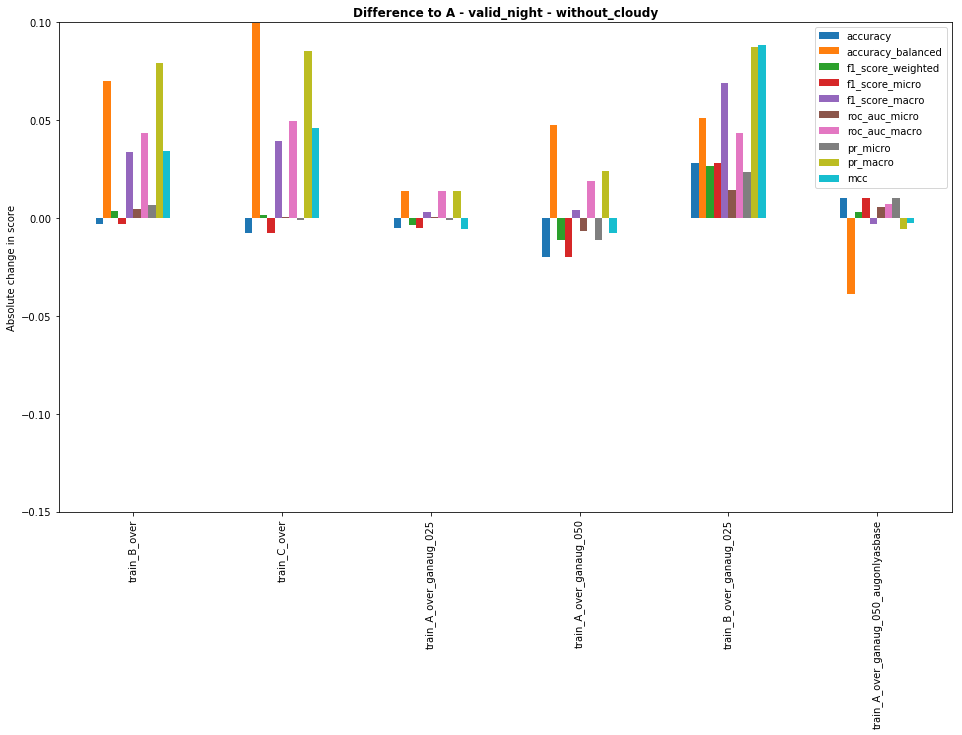

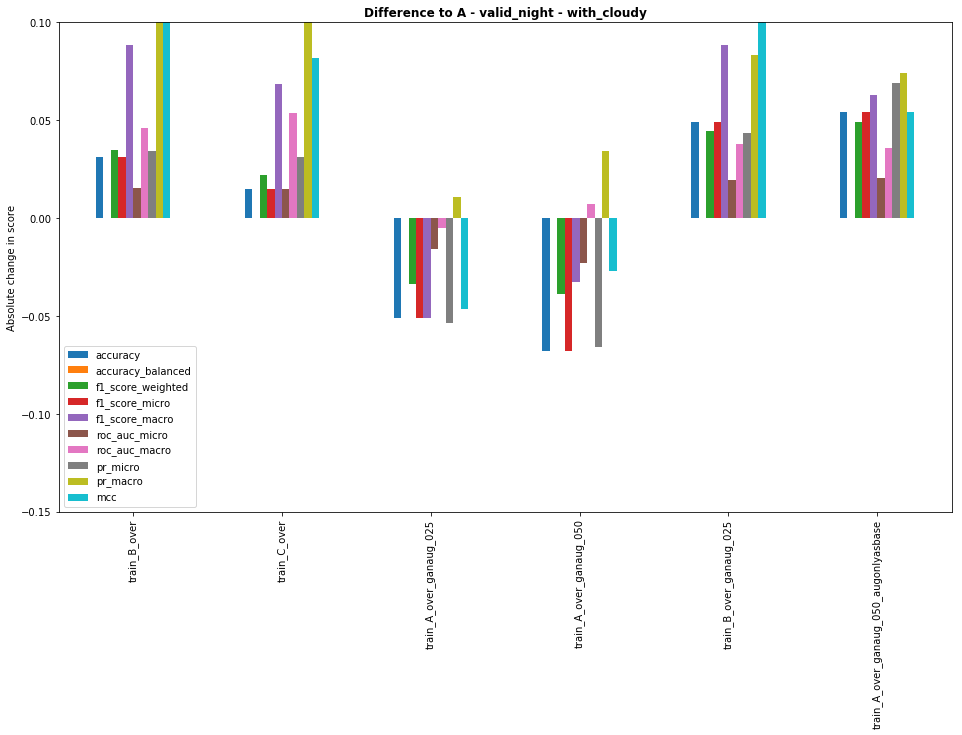

In [11]:
# plot difference
for trial in ["without_cloudy", "with_cloudy"]:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==trial, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:df_cursplit_plot.shape[0], :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {trial}", fontweight="bold")

#### Test-All

In [12]:
split = "test"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== test ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,40,train_A_over,without_cloudy,0.893041,0.784316,0.892044,0.893041,0.791867,0.968840,0.929549,0.945574,0.849390,0.700583
1,40,train_B_over,without_cloudy,0.893686,0.839249,0.896373,0.893686,0.811577,0.971062,0.943386,0.948017,0.881034,0.723942
2,40,train_C_over,without_cloudy,0.888531,0.831848,0.892048,0.888531,0.799317,0.969768,0.945515,0.945521,0.876282,0.714741
3,40,train_A_over_ganaug_025,without_cloudy,0.874356,0.778434,0.876185,0.874356,0.766362,0.966973,0.934093,0.943292,0.845613,0.662975
4,40,train_A_over_ganaug_050,without_cloudy,0.872423,0.808437,0.876975,0.872423,0.773689,0.962689,0.932805,0.935187,0.848532,0.676137
5,40,train_B_over_ganaug_025,without_cloudy,0.907216,0.808181,0.906498,0.907216,0.814890,0.974002,0.944380,0.954556,0.873301,0.740880
6,40,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.894330,0.773515,0.892296,0.894330,0.789699,0.969666,0.928996,0.946365,0.843960,0.699431
7,40,train_A_over,with_cloudy,0.842500,NaN,0.842002,0.842500,0.769192,0.957352,0.928833,0.896343,0.827548,0.719756
8,40,train_B_over,with_cloudy,0.845500,NaN,0.847093,0.845500,0.783595,0.959036,0.941317,0.894831,0.844906,0.731398
9,40,train_C_over,with_cloudy,0.849500,NaN,0.850207,0.849500,0.784015,0.960884,0.942846,0.901672,0.845498,0.735351


#### Test-Night

In [13]:
split = "test_night"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== test_night ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,40,train_A_over,without_cloudy,0.869474,0.648414,0.866014,0.869474,0.663411,0.951900,0.845422,0.913453,0.686719,0.518334
1,40,train_B_over,without_cloudy,0.872632,0.767789,0.878429,0.872632,0.726097,0.956871,0.888770,0.918725,0.784759,0.596105
2,40,train_C_over,without_cloudy,0.863158,0.752236,0.870917,0.863158,0.700694,0.953393,0.891864,0.912585,0.785979,0.579010
3,40,train_A_over_ganaug_025,without_cloudy,0.843158,0.646008,0.846696,0.843158,0.635367,0.951022,0.866091,0.914633,0.696527,0.467886
4,40,train_A_over_ganaug_050,without_cloudy,0.843158,0.709093,0.852438,0.843158,0.663023,0.943350,0.866074,0.898848,0.715014,0.517160
5,40,train_B_over_ganaug_025,without_cloudy,0.901053,0.724217,0.898670,0.901053,0.742339,0.965084,0.890424,0.936863,0.779434,0.636268
6,40,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.872632,0.622180,0.865285,0.872632,0.652387,0.954091,0.847949,0.914852,0.673306,0.508793
7,40,train_A_over,with_cloudy,0.851000,NaN,0.844845,0.851000,0.649404,0.949371,0.846767,0.882963,0.674098,0.544621
8,40,train_B_over,with_cloudy,0.854000,NaN,0.851642,0.854000,0.666722,0.954951,0.889316,0.885350,0.739498,0.581278
9,40,train_C_over,with_cloudy,0.858000,NaN,0.853619,0.858000,0.659759,0.957056,0.886673,0.894478,0.743259,0.581840


In [14]:
print("\n===", split, "Difference to A ===")
one_half = df_cursplit.shape[0]//2
df_cursplit_diff = df_cursplit.copy()
for col in df_cursplit.columns:
    if not isinstance(df_cursplit.loc[0,col], str):
        df_cursplit_diff.loc[0:one_half-1,col] = df_cursplit_diff.loc[0:one_half-1,col] - df_cursplit.loc[0,col]
        df_cursplit_diff.loc[one_half:one_half*2-1,col] = df_cursplit_diff.loc[one_half:one_half*2-1,col] - df_cursplit.loc[one_half,col]
df_cursplit_diff.loc[:, cols2print].head(df_cursplit_diff.shape[0])


=== test_night Difference to A ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,0,train_A_over,without_cloudy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,train_B_over,without_cloudy,0.003158,0.119375,0.012415,0.003158,0.062686,0.004971,0.043348,0.005273,0.098040,0.077771
2,0,train_C_over,without_cloudy,-0.006316,0.103822,0.004903,-0.006316,0.037284,0.001492,0.046442,-0.000867,0.099260,0.060675
3,0,train_A_over_ganaug_025,without_cloudy,-0.026316,-0.002406,-0.019318,-0.026316,-0.028044,-0.000879,0.020670,0.001181,0.009808,-0.050448
4,0,train_A_over_ganaug_050,without_cloudy,-0.026316,0.060678,-0.013576,-0.026316,-0.000387,-0.008551,0.020653,-0.014605,0.028295,-0.001175
5,0,train_B_over_ganaug_025,without_cloudy,0.031579,0.075803,0.032656,0.031579,0.078928,0.013183,0.045002,0.023410,0.092715,0.117933
6,0,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.003158,-0.026235,-0.000729,0.003158,-0.011024,0.002191,0.002527,0.001399,-0.013413,-0.009542
7,0,train_A_over,with_cloudy,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0,train_B_over,with_cloudy,0.003000,NaN,0.006797,0.003000,0.017318,0.005580,0.042548,0.002387,0.065400,0.036657
9,0,train_C_over,with_cloudy,0.007000,NaN,0.008774,0.007000,0.010355,0.007685,0.039906,0.011516,0.069161,0.037219


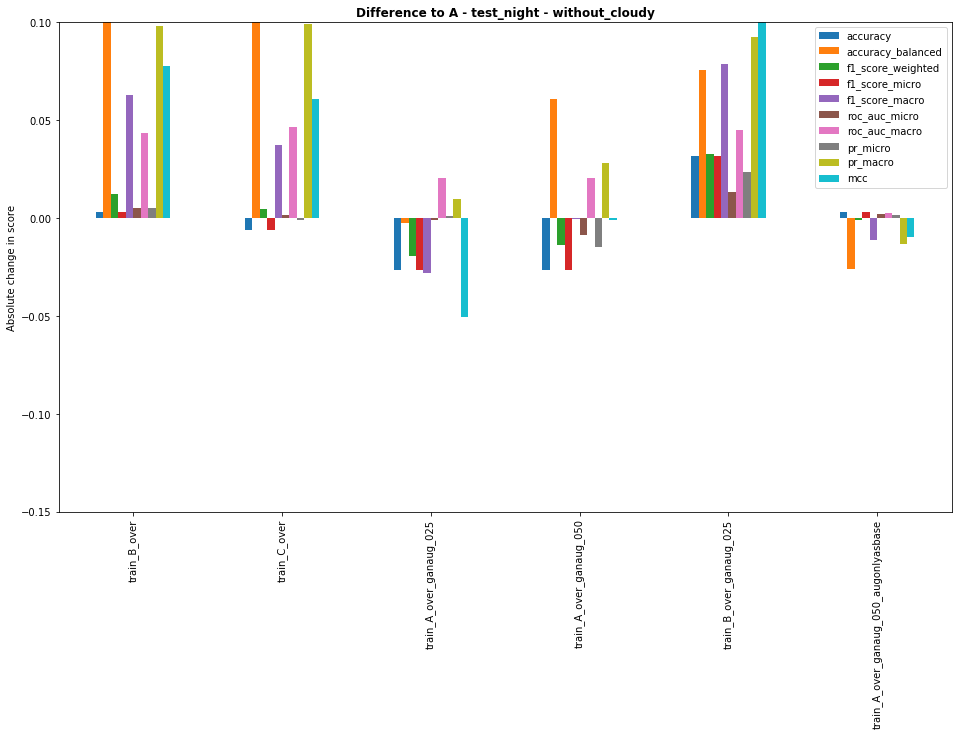

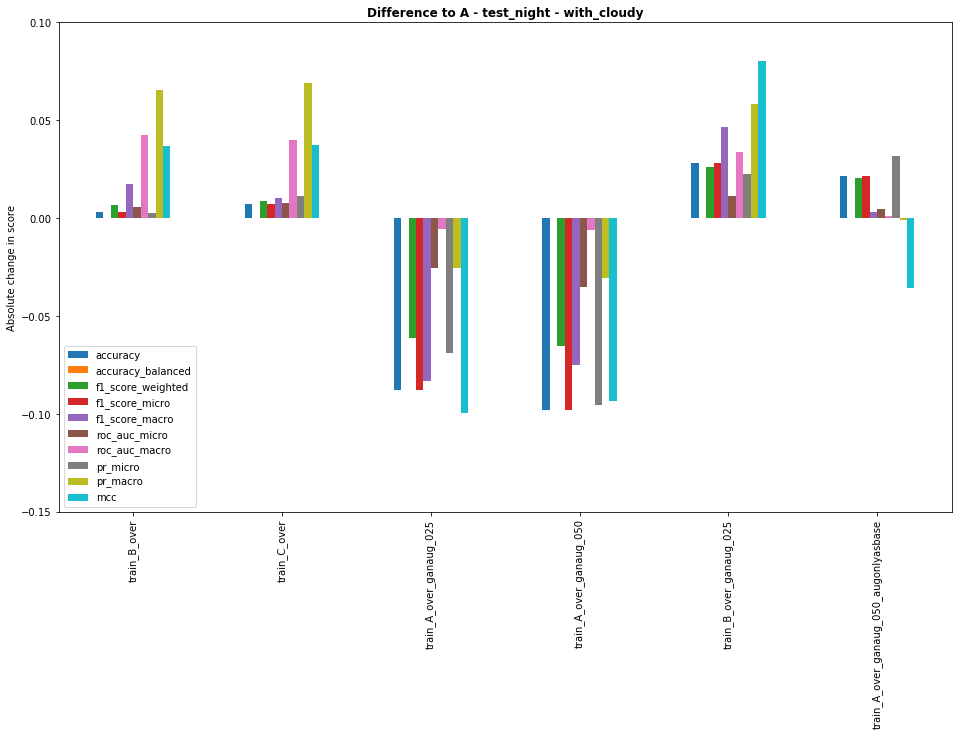

In [15]:
# plot difference
for trial in ["without_cloudy", "with_cloudy"]:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==trial, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:df_cursplit_plot.shape[0], :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {trial}", fontweight="bold")